In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

import logging
import warnings
from functools import partial

In [15]:
def simulate_gandk(theta, num_samples, c = 0.8):
    zu = np.random.randn(num_samples,1)
    f = (theta[0] + theta[1] * (1 + c * (1 - np.exp(-theta[2] * zu)) / (1 + np.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

def compute_summary_statistics(y):
    quant_y = []
    for i in np.arange(0.125, 1, 0.125):
        quant_y.append(np.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return np.array([Sa, Sb, Sc, Sd])

In [16]:
true_theta = np.array([3, 1, 2, 0.5])
sigma_theta = 10
sigma_latent = 1
num_coeffs = 4
num_latent = 4
num_datasets = 200
num_samples = 200

In [17]:
actual_data = simulate_gandk(true_theta, num_samples)
actual_data

array([[ 6.89282974],
       [ 3.3302241 ],
       [ 4.12448131],
       [ 2.76676572],
       [ 3.84372524],
       [ 2.37752795],
       [ 5.96133547],
       [ 2.99934038],
       [ 5.0774155 ],
       [ 2.34887207],
       [ 3.20928423],
       [ 2.25546768],
       [ 3.72646545],
       [ 4.38672345],
       [ 4.29574839],
       [10.1211876 ],
       [ 2.92423948],
       [ 5.63757262],
       [ 2.62963443],
       [ 2.43273327],
       [ 3.35682959],
       [ 2.8919376 ],
       [ 2.43004239],
       [ 2.3892397 ],
       [ 2.90585591],
       [ 6.00805604],
       [ 6.19094516],
       [ 2.75551042],
       [ 2.14415198],
       [ 2.78975007],
       [ 2.49831685],
       [ 2.50618753],
       [ 3.92940387],
       [ 5.77578069],
       [ 2.72138691],
       [ 2.84527858],
       [ 2.36074161],
       [ 2.69064277],
       [ 4.89608922],
       [16.88686326],
       [ 2.48621108],
       [ 5.76572029],
       [ 3.78501064],
       [ 4.17953514],
       [ 2.61800109],
       [ 3

In [18]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

array([2.96415549, 1.86720416, 0.52748722, 1.40542164])

In [19]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [20]:
def summary_statistics(theta, num_samples, num_datasets):
    n_summary_statistics = np.zeros((num_datasets, num_latent))
    for i in range(0, num_datasets):
        y = simulate_gandk(theta, num_samples)
        n_summary_statistics[i,:] = compute_summary_statistics(y)

    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [21]:
def mean_adjustment_summary_statistics(adjusted_theta, num_samples, num_datasets):
    theta = adjusted_theta[:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, num_samples, num_datasets)
    adjusted_sample_mean = sample_mean + np.diag(scipy.linalg.sqrtm(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [22]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def prior_gamma(gamma, sigma_latent, num_latent): 
    log_prior = multivariate_normal.logpdf(gamma, cov= sigma_latent * np.identity(num_latent))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, num_samples, num_datasets, actual_summary_statistics):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, num_samples, num_datasets)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_variance = mean_adj_ss[1]

    mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    # part1 = diff_mean_s.T @ my_inv(sample_variance) @ diff_mean_s
    # mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(sample_variance)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    part1 = (Gamma - mean_nuissance).T @ my_inv(variance_nuissance) @ (Gamma - mean_nuissance)
    nuissance_mean_u_est_log_likelihood = -1/2 * np.linalg.slogdet(variance_nuissance)[1] - part1
    # nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [23]:
Sigma_0 = np.array([[0.00354862371705708,0.0100432715000140,-0.00892228604398757,-0.0115360428708387],
                   [0.0100432715000140,0.0583090115606533,-0.000835188303313756,-0.0757252081004190],
                   [-0.00892228604398757,-0.000835188303313756,0.0653624479615574,0.0107535785728523],
                   [-0.0115360428708387,-0.0757252081004190,0.0107535785728523,0.167430224841150]])
Sigma_0_inv = scipy.linalg.inv(Sigma_0)
l_0 = scipy.linalg.sqrtm(Sigma_0_inv)
l_0

array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
       [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
       [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
       [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

In [24]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([true_theta[0], np.log(true_theta[1]), true_theta[2], np.log(true_theta[3])])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        l_0 = np.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                        [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                        [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                        [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in tqdm(range(self.samples)):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    # alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    # beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    # gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))

                    alpha_0 = theta_tilde_0[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_0 = np.exp(theta_tilde_0[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_0 = theta_tilde_0[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_0 = np.exp(theta_tilde_0[3])

                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])
                    
                    ss_0 = summary_statistics(theta_0, num_samples, num_datasets)
                    sample_mean_0 = ss_0[0]
                    sample_variance_0 = ss_0[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(sample_variance_0))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance_0) @ diag_var)
                    diff_mean = actual_summary_statistics - sample_mean_0
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_0) @ diff_mean
                    mean_nuissance_0 = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_0 = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_0, cov = variance_nuissance_0)
                    # Gamma = Gamma[0]
                    adjusted_theta_0 = np.concatenate((theta_0, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_0, num_samples, num_datasets, actual_summary_statistics)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_0, variance_nuissance_0)

                    h_lambda_init = prior(theta_tilde_0) + prior_gamma(Gamma, sigma_latent, num_latent) + llh - self.fun_log_q(theta_tilde_0, mu_0, l_0) - llh_gamma

                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = theta_tilde_q[0]
                    # beta_q = (0.05 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    beta_q = np.exp(theta_tilde_q[1])
                    # gamma_q = (np.exp(theta_tilde_q[2]) - 1) / (1 + np.exp(theta_tilde_q[2]))
                    gamma_q = theta_tilde_q[2]
                    # delta_q = (0.5 * np.exp(theta_tilde_q[3]) + 0.2) / (1 + np.exp(theta_tilde_q[3]))                    theta_q = np.array([alpha_q, beta_q, gamma_q])
                    delta_q = np.exp(theta_tilde_q[3])

                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    
                    ss_q = summary_statistics(theta_q, num_samples, num_datasets)
                    sample_mean_q = ss_q[0]
                    sample_variance_q = ss_q[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_var = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_var, np.diag(sample_variance_q))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance_q) @ diag_var)
                    diff_mean = actual_summary_statistics - sample_mean_q
                    mean_nuissance_p2 = diag_var @ my_inv(sample_variance_q) @ diff_mean
                    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_q = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

                    # GENERATE GAMMA
                    rng = np.random.default_rng()
                    Gamma = rng.multivariate_normal(mean = mean_nuissance_q, cov = variance_nuissance_q)
                    # Gamma = Gamma[0]
                    adjusted_theta_q = np.concatenate((theta_q, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, num_samples, num_datasets, actual_summary_statistics)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)


                    # Find gradient of LB
                    h_lambda = prior(theta_tilde_q) + prior_gamma(Gamma, sigma_latent, num_latent) + llh - self.fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [25]:
# Set hyperparameters
stop = 5000
vb = GVB(400, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 100, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [02:18<192:03:52, 138.31s/it]

LB 120.33137792370499


  0%|          | 2/5000 [05:16<224:16:09, 161.54s/it]

LB 98.27241152141734


  0%|          | 3/5000 [08:57<261:51:40, 188.65s/it]

LB 99.80058590613785


  0%|          | 4/5000 [12:23<271:48:39, 195.86s/it]

LB 100.9654443163365


  0%|          | 5/5000 [15:50<277:03:17, 199.68s/it]

LB 100.72791640747391


  0%|          | 6/5000 [19:12<278:18:13, 200.62s/it]

LB 100.81233431642657


  0%|          | 7/5000 [21:57<261:47:41, 188.76s/it]

LB 101.085262584698


  0%|          | 8/5000 [24:25<243:43:28, 175.76s/it]

LB 100.40579274086981


  0%|          | 9/5000 [27:19<243:14:41, 175.45s/it]

LB 99.55284546753856


  0%|          | 10/5000 [29:47<231:16:02, 166.85s/it]

LB 100.43064011279155


  0%|          | 11/5000 [32:15<223:06:26, 160.99s/it]

LB 99.82525642000296


  0%|          | 12/5000 [34:43<217:33:13, 157.02s/it]

LB 100.6860734295451


  0%|          | 13/5000 [37:11<213:58:03, 154.46s/it]

LB 98.63520338786755


  0%|          | 14/5000 [39:36<210:03:50, 151.67s/it]

LB 98.92436861472292


  0%|          | 15/5000 [42:06<209:18:51, 151.16s/it]

LB 98.7847399186903


  0%|          | 16/5000 [44:36<208:39:13, 150.71s/it]

LB 98.91180315885867


  0%|          | 17/5000 [47:06<208:07:45, 150.36s/it]

LB 100.77810203113987


  0%|          | 18/5000 [49:37<208:27:54, 150.64s/it]

LB 99.99482397355722


  0%|          | 19/5000 [52:11<209:57:55, 151.75s/it]

LB 101.23135331387599


  0%|          | 20/5000 [54:48<211:51:50, 153.15s/it]

LB 100.48124336892164


  0%|          | 21/5000 [57:24<213:10:52, 154.14s/it]

LB 99.98820363008926


  0%|          | 22/5000 [59:57<212:41:35, 153.82s/it]

LB 99.81252526219643


  0%|          | 23/5000 [1:02:31<212:34:42, 153.76s/it]

LB 99.85721521167241


  0%|          | 24/5000 [1:05:05<212:50:01, 153.98s/it]

LB 99.84279128216244


  0%|          | 25/5000 [1:07:39<212:42:28, 153.92s/it]

LB 99.26887431700216


  1%|          | 26/5000 [1:10:28<218:51:28, 158.40s/it]

LB 99.04733233619862


  1%|          | 27/5000 [1:13:21<224:46:44, 162.72s/it]

LB 99.95654259897412


  1%|          | 28/5000 [1:16:14<229:01:13, 165.82s/it]

LB 99.65608862211943


  1%|          | 29/5000 [1:18:46<223:18:31, 161.72s/it]

LB 100.56831549303392


  1%|          | 30/5000 [1:21:18<219:06:11, 158.71s/it]

LB 97.5227263238046


  1%|          | 31/5000 [1:23:49<216:03:05, 156.53s/it]

LB 98.13738364228116


  1%|          | 32/5000 [1:26:24<215:30:09, 156.16s/it]

LB 97.9705283105389


  1%|          | 33/5000 [1:28:58<214:17:27, 155.31s/it]

LB 96.57468851979574


  1%|          | 34/5000 [1:31:28<212:19:22, 153.92s/it]

LB 98.94790965699816


  1%|          | 35/5000 [1:34:00<211:19:50, 153.23s/it]

LB 98.20113844951088


  1%|          | 36/5000 [1:36:35<212:03:56, 153.79s/it]

LB 99.13680315609454


  1%|          | 37/5000 [1:39:03<209:36:25, 152.04s/it]

LB 98.22061823432976


  1%|          | 38/5000 [1:41:30<207:26:03, 150.50s/it]

LB 98.10747771822409


  1%|          | 39/5000 [1:43:58<206:32:21, 149.88s/it]

LB 97.42609224096407


  1%|          | 40/5000 [1:46:27<205:48:44, 149.38s/it]

LB 98.39529810140303


  1%|          | 41/5000 [1:48:56<205:52:58, 149.46s/it]

LB 97.86810569870543


  1%|          | 42/5000 [1:51:25<205:22:31, 149.12s/it]

LB 97.40078348781864


  1%|          | 43/5000 [1:53:54<205:23:03, 149.16s/it]

LB 97.95094775766242


  1%|          | 44/5000 [1:56:23<205:15:59, 149.10s/it]

LB 100.3020620658589


  1%|          | 45/5000 [1:58:53<205:41:51, 149.45s/it]

LB 98.29628440292754


  1%|          | 46/5000 [2:01:21<205:15:22, 149.16s/it]

LB 97.67371546979577


  1%|          | 47/5000 [2:03:50<204:49:41, 148.88s/it]

LB 98.80924652371691


  1%|          | 48/5000 [2:06:19<204:46:08, 148.86s/it]

LB 96.72076675436982


  1%|          | 49/5000 [2:08:47<204:32:04, 148.72s/it]

LB 95.72694203317559


  1%|          | 50/5000 [2:11:14<203:59:42, 148.36s/it]

LB 98.2571717625998


  1%|          | 51/5000 [2:13:43<203:55:58, 148.34s/it]

LB 97.15067195324177


  1%|          | 52/5000 [2:16:10<203:34:14, 148.11s/it]

LB 97.35768283640839


  1%|          | 53/5000 [2:18:38<203:27:57, 148.07s/it]

LB 99.48791805970451


  1%|          | 54/5000 [2:21:04<202:35:30, 147.46s/it]

LB 97.04451869417893


  1%|          | 55/5000 [2:23:31<202:21:21, 147.32s/it]

LB 98.40592739481046


  1%|          | 56/5000 [2:26:00<202:46:11, 147.65s/it]

LB 96.92298822142104


  1%|          | 57/5000 [2:28:28<202:49:01, 147.71s/it]

LB 98.88883725068744


  1%|          | 58/5000 [2:30:54<202:08:12, 147.25s/it]

LB 98.29935449362767


  1%|          | 59/5000 [2:33:21<202:09:23, 147.29s/it]

LB 96.69270601111475


  1%|          | 60/5000 [2:35:47<201:37:52, 146.94s/it]

LB 100.66674543414216


  1%|          | 61/5000 [2:38:18<203:20:02, 148.21s/it]

LB 98.39263730323314


  1%|          | 62/5000 [2:40:44<202:12:47, 147.42s/it]

LB 96.89904416051515


  1%|▏         | 63/5000 [2:43:10<201:45:48, 147.12s/it]

LB 96.28433158481864


  1%|▏         | 64/5000 [2:45:36<201:13:06, 146.76s/it]

LB 96.48367298335047


  1%|▏         | 65/5000 [2:48:04<201:20:23, 146.87s/it]

LB 96.25110489979896


  1%|▏         | 66/5000 [2:50:30<200:59:07, 146.65s/it]

LB 98.52862047957788


  1%|▏         | 67/5000 [2:52:56<200:50:08, 146.57s/it]

LB 101.72013384989357


  1%|▏         | 68/5000 [2:55:23<200:51:23, 146.61s/it]

LB 96.21139567455434


  1%|▏         | 69/5000 [2:57:50<201:04:36, 146.80s/it]

LB 101.1341647879261


  1%|▏         | 70/5000 [3:00:17<201:09:26, 146.89s/it]

LB 98.84412800207986


  1%|▏         | 71/5000 [3:02:43<200:47:55, 146.66s/it]

LB 97.54451339966569


  1%|▏         | 72/5000 [3:05:11<201:10:31, 146.96s/it]

LB 98.17071009167579


  1%|▏         | 73/5000 [3:07:38<201:08:39, 146.97s/it]

LB 99.12242881087161


  1%|▏         | 74/5000 [3:10:05<201:06:07, 146.97s/it]

LB 98.52390499498757


  2%|▏         | 75/5000 [3:12:31<200:51:33, 146.82s/it]

LB 97.80123975362442


  2%|▏         | 76/5000 [3:14:58<200:36:33, 146.67s/it]

LB 100.0039895558665


  2%|▏         | 77/5000 [3:17:24<200:27:16, 146.58s/it]

LB 99.5288500409896


  2%|▏         | 78/5000 [3:19:51<200:35:38, 146.72s/it]

LB 100.80796193753442


  2%|▏         | 79/5000 [3:22:18<200:33:52, 146.72s/it]

LB 101.27250164472508


  2%|▏         | 80/5000 [3:24:46<200:58:35, 147.06s/it]

LB 101.55951277435099


  2%|▏         | 81/5000 [3:27:13<201:08:53, 147.21s/it]

LB 100.6851762496345


  2%|▏         | 82/5000 [3:29:47<203:46:34, 149.17s/it]

LB 100.18237657526599


  2%|▏         | 83/5000 [3:32:42<214:21:56, 156.95s/it]

LB 99.29964031811753


  2%|▏         | 84/5000 [3:35:14<212:18:35, 155.48s/it]

LB 100.58713924449465


  2%|▏         | 85/5000 [3:38:16<223:08:46, 163.44s/it]

LB 102.59484799206167


  2%|▏         | 86/5000 [3:41:19<231:00:37, 169.24s/it]

LB 104.77582089510291


  2%|▏         | 87/5000 [3:43:48<222:55:46, 163.35s/it]

LB 104.583198299624


  2%|▏         | 88/5000 [3:46:14<215:42:38, 158.09s/it]

LB 101.86978419490333


  2%|▏         | 89/5000 [3:48:40<210:45:35, 154.50s/it]

LB 102.75526321089636


  2%|▏         | 90/5000 [3:51:07<207:21:23, 152.03s/it]

LB 103.767662535657


  2%|▏         | 91/5000 [3:53:33<204:51:45, 150.24s/it]

LB 102.85063679933587


  2%|▏         | 92/5000 [3:55:59<203:09:45, 149.02s/it]

LB 102.73682354211107


  2%|▏         | 93/5000 [3:58:25<201:52:59, 148.11s/it]

LB 103.36625183583506


  2%|▏         | 94/5000 [4:00:51<201:04:48, 147.55s/it]

LB 105.28858078146304


  2%|▏         | 95/5000 [4:03:17<200:13:28, 146.95s/it]

LB 104.24986767896364


  2%|▏         | 96/5000 [4:05:44<200:08:42, 146.93s/it]

LB 107.01243376441985


  2%|▏         | 97/5000 [4:08:11<200:10:44, 146.98s/it]

LB 107.38488434636882


  2%|▏         | 98/5000 [4:10:37<200:04:30, 146.93s/it]

LB 104.13534460991472


  2%|▏         | 99/5000 [4:13:03<199:37:33, 146.63s/it]

LB 105.58052370568166


  2%|▏         | 100/5000 [4:15:30<199:32:39, 146.60s/it]

LB 106.48134097940583


  2%|▏         | 101/5000 [4:17:56<199:16:57, 146.44s/it]

LB Smoothed 99.81960176458112


  2%|▏         | 102/5000 [4:20:22<199:01:33, 146.28s/it]

LB Smoothed 99.9218502059393


  2%|▏         | 103/5000 [4:22:47<198:39:21, 146.04s/it]

LB Smoothed 99.9927795286128


  2%|▏         | 104/5000 [4:25:14<198:43:16, 146.12s/it]

LB Smoothed 100.07892426183753


  2%|▏         | 105/5000 [4:27:39<198:29:36, 145.98s/it]

LB Smoothed 100.18849236015289


  2%|▏         | 106/5000 [4:30:06<198:43:45, 146.18s/it]

LB Smoothed 100.27494537376522


  2%|▏         | 107/5000 [4:32:32<198:41:04, 146.18s/it]

LB Smoothed 100.32185592181109


  2%|▏         | 108/5000 [4:34:58<198:37:07, 146.16s/it]

LB Smoothed 100.43723357961674


  2%|▏         | 109/5000 [4:37:25<198:51:31, 146.37s/it]

LB Smoothed 100.56012213567085


  2%|▏         | 110/5000 [4:39:52<198:55:38, 146.45s/it]

LB Smoothed 100.6601503831349


  2%|▏         | 111/5000 [4:42:18<198:54:53, 146.47s/it]

LB Smoothed 100.73061669471168


  2%|▏         | 112/5000 [4:44:45<198:59:59, 146.56s/it]

LB Smoothed 100.84440775302762


  2%|▏         | 113/5000 [4:47:13<199:25:53, 146.91s/it]

LB Smoothed 100.9784750096646


  2%|▏         | 114/5000 [4:49:39<199:17:39, 146.84s/it]

LB Smoothed 101.16848321322603


  2%|▏         | 115/5000 [4:52:07<199:25:02, 146.96s/it]

LB Smoothed 101.31195679727395


  2%|▏         | 116/5000 [4:54:34<199:23:06, 146.97s/it]

LB Smoothed 101.45724197698898


  2%|▏         | 117/5000 [4:57:01<199:21:43, 146.98s/it]

LB Smoothed 101.64322222431592


  2%|▏         | 118/5000 [4:59:28<199:29:48, 147.11s/it]

LB Smoothed 101.77238884997219


  2%|▏         | 119/5000 [5:01:55<199:16:12, 146.97s/it]

LB Smoothed 101.8854081903054


  2%|▏         | 120/5000 [5:04:21<198:57:43, 146.78s/it]

LB Smoothed 102.0171387611052


  2%|▏         | 121/5000 [5:06:47<198:42:00, 146.61s/it]

LB Smoothed 102.19259461310388


  2%|▏         | 122/5000 [5:09:14<198:31:13, 146.51s/it]

LB Smoothed 102.36582875529128


  2%|▏         | 123/5000 [5:11:41<198:46:56, 146.73s/it]

LB Smoothed 102.55381324525207


  2%|▏         | 124/5000 [5:14:09<199:14:49, 147.11s/it]

LB Smoothed 102.75440981577123


  2%|▎         | 125/5000 [5:16:35<198:59:02, 146.94s/it]

LB Smoothed 103.00921371692391


  3%|▎         | 126/5000 [5:19:01<198:26:59, 146.58s/it]

LB Smoothed 103.22896710439235


  3%|▎         | 127/5000 [5:21:28<198:22:46, 146.56s/it]

LB Smoothed 103.46574259978073


  3%|▎         | 128/5000 [5:23:56<198:58:59, 147.03s/it]

LB Smoothed 103.68536725285871


  3%|▎         | 129/5000 [5:26:23<199:02:57, 147.11s/it]

LB Smoothed 103.9516199219215


  3%|▎         | 130/5000 [5:28:50<199:03:27, 147.15s/it]

LB Smoothed 104.24248085722836


  3%|▎         | 131/5000 [5:31:16<198:37:36, 146.86s/it]

LB Smoothed 104.52272951555204


  3%|▎         | 132/5000 [5:33:45<199:19:57, 147.41s/it]

LB Smoothed 104.7728156356482


  3%|▎         | 133/5000 [5:36:14<199:44:43, 147.75s/it]

LB Smoothed 105.07216044048945


  3%|▎         | 134/5000 [5:38:42<199:45:53, 147.79s/it]

LB Smoothed 105.37871082532808


  3%|▎         | 135/5000 [5:41:09<199:38:22, 147.73s/it]

LB Smoothed 105.67184343794906


  3%|▎         | 136/5000 [5:43:36<199:18:35, 147.52s/it]

LB Smoothed 105.9771247802565


  3%|▎         | 137/5000 [5:46:03<199:01:07, 147.33s/it]

LB Smoothed 106.30644809608894


  3%|▎         | 138/5000 [5:48:32<199:28:51, 147.70s/it]

LB Smoothed 106.63750485203227


  3%|▎         | 139/5000 [5:50:58<199:02:34, 147.41s/it]

LB Smoothed 106.9939799727005


  3%|▎         | 140/5000 [5:53:24<198:12:32, 146.82s/it]

LB Smoothed 107.35091407493537


  3%|▎         | 141/5000 [5:55:50<197:55:03, 146.64s/it]

LB Smoothed 107.72437507093208


  3%|▎         | 142/5000 [5:58:16<197:46:14, 146.56s/it]

LB Smoothed 108.09924550248607


  3%|▎         | 143/5000 [6:01:02<205:19:20, 152.18s/it]

LB Smoothed 108.48232262767362


  3%|▎         | 144/5000 [6:04:20<223:59:41, 166.06s/it]

LB Smoothed 108.88651423978227


  3%|▎         | 145/5000 [6:07:42<238:33:21, 176.89s/it]

LB Smoothed 109.26766481180952


  3%|▎         | 146/5000 [6:11:00<246:49:21, 183.06s/it]

LB Smoothed 109.66293292002774


  3%|▎         | 147/5000 [6:14:18<252:45:23, 187.50s/it]

LB Smoothed 110.1039532362965


  3%|▎         | 148/5000 [6:17:38<257:49:26, 191.30s/it]

LB Smoothed 110.4964583329398


  3%|▎         | 149/5000 [6:21:01<262:30:12, 194.81s/it]

LB Smoothed 110.93419990815833


  3%|▎         | 150/5000 [6:24:23<265:19:55, 196.95s/it]

LB Smoothed 111.40808912763995


  3%|▎         | 151/5000 [6:27:43<266:45:29, 198.05s/it]

LB Smoothed 111.86951227595385


  3%|▎         | 152/5000 [6:31:09<269:36:42, 200.21s/it]

LB Smoothed 112.35795879729811


  3%|▎         | 153/5000 [6:34:31<270:21:41, 200.81s/it]

LB Smoothed 112.82339236943355


  3%|▎         | 154/5000 [6:37:51<270:06:02, 200.65s/it]

LB Smoothed 113.31936051753524


  3%|▎         | 155/5000 [6:40:58<264:39:14, 196.65s/it]

LB Smoothed 113.80794702895986


  3%|▎         | 156/5000 [6:43:29<245:58:16, 182.80s/it]

LB Smoothed 114.3302121831697


  3%|▎         | 157/5000 [6:46:00<233:18:37, 173.43s/it]

LB Smoothed 114.84093536517844


  3%|▎         | 158/5000 [6:48:35<225:31:20, 167.67s/it]

LB Smoothed 115.36533733268432


  3%|▎         | 159/5000 [6:51:10<220:38:35, 164.08s/it]

LB Smoothed 115.9344350621505


  3%|▎         | 160/5000 [6:53:41<215:06:53, 160.00s/it]

LB Smoothed 116.46622862332067


  3%|▎         | 161/5000 [6:56:13<211:58:29, 157.70s/it]

LB Smoothed 116.99469233121631


  3%|▎         | 162/5000 [6:58:45<209:25:43, 155.84s/it]

LB Smoothed 117.63774603193433


  3%|▎         | 163/5000 [7:01:13<206:25:53, 153.64s/it]

LB Smoothed 118.24548420810079


  3%|▎         | 164/5000 [7:03:43<204:51:13, 152.50s/it]

LB Smoothed 118.88941517340295


  3%|▎         | 165/5000 [7:06:14<204:02:39, 151.93s/it]

LB Smoothed 119.55835606310451


  3%|▎         | 166/5000 [7:08:43<202:54:56, 151.12s/it]

LB Smoothed 120.21177083572634


  3%|▎         | 167/5000 [7:11:13<202:38:48, 150.95s/it]

LB Smoothed 120.75171098661836


  3%|▎         | 168/5000 [7:13:43<202:12:58, 150.66s/it]

LB Smoothed 121.40053593110703


  3%|▎         | 169/5000 [7:16:13<201:36:41, 150.24s/it]

LB Smoothed 122.05794981948446


  3%|▎         | 170/5000 [7:18:47<203:02:51, 151.34s/it]

LB Smoothed 122.76410896837002


  3%|▎         | 171/5000 [7:21:15<201:51:27, 150.48s/it]

LB Smoothed 123.49429555496184


  3%|▎         | 172/5000 [7:23:44<201:23:34, 150.17s/it]

LB Smoothed 124.20615441334299


  3%|▎         | 173/5000 [7:26:16<201:48:23, 150.51s/it]

LB Smoothed 124.91386528507002


  3%|▎         | 174/5000 [7:28:47<201:55:37, 150.63s/it]

LB Smoothed 125.64817658871169


  4%|▎         | 175/5000 [7:31:17<201:49:42, 150.59s/it]

LB Smoothed 126.40505671111798


  4%|▎         | 176/5000 [7:33:48<201:43:10, 150.54s/it]

LB Smoothed 127.13678622501907


  4%|▎         | 177/5000 [7:36:19<201:58:27, 150.76s/it]

LB Smoothed 127.86821675259394


  4%|▎         | 178/5000 [7:38:50<201:52:53, 150.72s/it]

LB Smoothed 128.65141247785607


  4%|▎         | 179/5000 [7:41:19<201:31:43, 150.49s/it]

LB Smoothed 129.45735261339914


  4%|▎         | 180/5000 [7:43:51<201:47:43, 150.72s/it]

LB Smoothed 130.29743625225962


  4%|▎         | 181/5000 [7:46:20<201:21:21, 150.42s/it]

LB Smoothed 131.11956318186893


  4%|▎         | 182/5000 [7:48:54<202:40:39, 151.44s/it]

LB Smoothed 131.9823915129636


  4%|▎         | 183/5000 [7:51:24<202:04:36, 151.02s/it]

LB Smoothed 132.82088900773874


  4%|▎         | 184/5000 [7:54:00<203:52:53, 152.40s/it]

LB Smoothed 133.6640639793892


  4%|▎         | 185/5000 [7:56:31<203:20:07, 152.03s/it]

LB Smoothed 134.53496360712586


  4%|▎         | 186/5000 [7:59:03<203:25:21, 152.12s/it]

LB Smoothed 135.40603075075649


  4%|▎         | 187/5000 [8:01:34<202:52:25, 151.74s/it]

LB Smoothed 136.25251469211184


  4%|▍         | 188/5000 [8:04:06<202:43:32, 151.67s/it]

LB Smoothed 137.2106504333254


  4%|▍         | 189/5000 [8:06:36<202:01:49, 151.18s/it]

LB Smoothed 138.2080511143747


  4%|▍         | 190/5000 [8:09:08<202:19:50, 151.43s/it]

LB Smoothed 139.2293525002618


  4%|▍         | 191/5000 [8:11:39<202:19:43, 151.46s/it]

LB Smoothed 140.26440809444495


  4%|▍         | 192/5000 [8:14:12<202:45:46, 151.82s/it]

LB Smoothed 141.32415843939293


  4%|▍         | 193/5000 [8:16:43<202:27:11, 151.62s/it]

LB Smoothed 142.34593106099467


  4%|▍         | 194/5000 [8:19:15<202:41:10, 151.82s/it]

LB Smoothed 143.4470729512294


  4%|▍         | 195/5000 [8:21:48<202:54:25, 152.02s/it]

LB Smoothed 144.53218540073834


  4%|▍         | 196/5000 [8:24:20<202:53:04, 152.04s/it]

LB Smoothed 145.55985820437638


  4%|▍         | 197/5000 [8:26:52<202:57:06, 152.12s/it]

LB Smoothed 146.53799423726457


  4%|▍         | 198/5000 [8:29:23<202:29:45, 151.81s/it]

LB Smoothed 147.70786046976247


  4%|▍         | 199/5000 [8:31:54<201:56:23, 151.42s/it]

LB Smoothed 148.85644421231757


  4%|▍         | 200/5000 [8:34:23<201:07:25, 150.84s/it]

LB Smoothed 150.03215890373772


  4%|▍         | 201/5000 [8:36:52<200:10:12, 150.16s/it]

LB Smoothed 151.23159570165768


  4%|▍         | 202/5000 [8:39:20<199:22:05, 149.59s/it]

LB Smoothed 152.41957938614686


  4%|▍         | 203/5000 [8:41:49<198:55:24, 149.29s/it]

LB Smoothed 153.7089476478594


  4%|▍         | 204/5000 [8:44:20<199:41:17, 149.89s/it]

LB Smoothed 154.89475283125932


  4%|▍         | 205/5000 [8:46:50<199:33:32, 149.83s/it]

LB Smoothed 156.12143245099432


  4%|▍         | 206/5000 [8:49:21<199:56:44, 150.15s/it]

LB Smoothed 157.3607553999197


  4%|▍         | 207/5000 [8:51:51<199:57:36, 150.19s/it]

LB Smoothed 158.64552206401066


  4%|▍         | 208/5000 [8:54:23<200:32:27, 150.66s/it]

LB Smoothed 160.01756490810422


  4%|▍         | 209/5000 [8:56:54<200:39:37, 150.78s/it]

LB Smoothed 161.3125792821656


  4%|▍         | 210/5000 [8:59:23<200:07:35, 150.41s/it]

LB Smoothed 162.71874693793663


  4%|▍         | 211/5000 [9:01:54<200:19:15, 150.59s/it]

LB Smoothed 164.11215088826899


  4%|▍         | 212/5000 [9:04:25<200:24:57, 150.69s/it]

LB Smoothed 165.48647741769577


  4%|▍         | 213/5000 [9:06:56<200:33:46, 150.83s/it]

LB Smoothed 166.8074302179222


  4%|▍         | 214/5000 [9:09:25<199:42:41, 150.22s/it]

LB Smoothed 168.23102255955976


  4%|▍         | 215/5000 [9:12:06<204:03:03, 153.52s/it]

LB Smoothed 169.73265629332812


  4%|▍         | 216/5000 [9:14:52<208:57:54, 157.25s/it]

LB Smoothed 171.21125977718535


  4%|▍         | 217/5000 [9:17:39<212:37:07, 160.03s/it]

LB Smoothed 172.72259108855903


  4%|▍         | 218/5000 [9:20:23<214:20:50, 161.37s/it]

LB Smoothed 174.36813004037398


  4%|▍         | 219/5000 [9:23:10<216:21:34, 162.91s/it]

LB Smoothed 175.98953009650901


  4%|▍         | 220/5000 [9:25:51<215:46:38, 162.51s/it]

LB Smoothed 177.69703459495628


  4%|▍         | 221/5000 [9:26:46<172:46:54, 130.16s/it]

LB Smoothed 179.27962193968173


  4%|▍         | 222/5000 [9:27:40<142:13:36, 107.16s/it]

LB Smoothed 180.93017147194024


  4%|▍         | 223/5000 [9:28:32<120:17:29, 90.65s/it] 

LB Smoothed 182.53213337556426


  4%|▍         | 224/5000 [9:29:22<104:06:22, 78.47s/it]

LB Smoothed 184.1576186870011


  4%|▍         | 225/5000 [9:30:14<93:36:10, 70.57s/it] 

LB Smoothed 185.74959671562925


  5%|▍         | 226/5000 [9:31:06<86:18:16, 65.08s/it]

LB Smoothed 187.43287853881864


  5%|▍         | 227/5000 [9:31:56<80:07:51, 60.44s/it]

LB Smoothed 189.21022437780647


  5%|▍         | 228/5000 [9:32:47<76:15:53, 57.53s/it]

LB Smoothed 190.9730779629697


  5%|▍         | 229/5000 [9:33:39<74:16:17, 56.04s/it]

LB Smoothed 192.7559802547744


  5%|▍         | 230/5000 [9:34:33<73:16:33, 55.30s/it]

LB Smoothed 194.60625391469097


  5%|▍         | 231/5000 [9:35:27<72:50:38, 54.99s/it]

LB Smoothed 196.43006215467844


  5%|▍         | 232/5000 [9:36:21<72:29:33, 54.73s/it]

LB Smoothed 198.28142739727673


  5%|▍         | 233/5000 [9:37:14<71:36:12, 54.07s/it]

LB Smoothed 200.18241075632258


  5%|▍         | 234/5000 [9:38:09<72:12:57, 54.55s/it]

LB Smoothed 201.95333266000875


  5%|▍         | 235/5000 [9:39:04<72:21:31, 54.67s/it]

LB Smoothed 203.80831536762784


  5%|▍         | 236/5000 [9:39:53<69:58:23, 52.88s/it]

LB Smoothed 205.82176411974922


  5%|▍         | 237/5000 [9:40:41<67:51:28, 51.29s/it]

LB Smoothed 207.8234551086296


  5%|▍         | 238/5000 [9:41:28<66:26:46, 50.23s/it]

LB Smoothed 209.8719347162144


  5%|▍         | 239/5000 [9:42:16<65:30:14, 49.53s/it]

LB Smoothed 211.9919752801814


  5%|▍         | 240/5000 [9:43:04<64:49:49, 49.03s/it]

LB Smoothed 213.90532287178826


  5%|▍         | 241/5000 [9:43:52<64:26:11, 48.74s/it]

LB Smoothed 215.98901183513362


  5%|▍         | 242/5000 [9:44:40<63:59:46, 48.42s/it]

LB Smoothed 217.99352538191886


  5%|▍         | 243/5000 [9:45:27<63:36:27, 48.14s/it]

LB Smoothed 220.11570956481287


  5%|▍         | 244/5000 [9:46:15<63:23:15, 47.98s/it]

LB Smoothed 222.47401527461938


  5%|▍         | 245/5000 [9:47:03<63:18:02, 47.92s/it]

LB Smoothed 224.69212275405403


  5%|▍         | 246/5000 [9:47:51<63:20:52, 47.97s/it]

LB Smoothed 226.88695975270755


  5%|▍         | 247/5000 [9:48:39<63:17:01, 47.93s/it]

LB Smoothed 229.1819793925979


  5%|▍         | 248/5000 [9:49:27<63:19:53, 47.98s/it]

LB Smoothed 231.44901537921206


  5%|▍         | 249/5000 [9:50:15<63:18:52, 47.98s/it]

LB Smoothed 233.8264665808769


  5%|▌         | 250/5000 [9:51:03<63:19:47, 48.00s/it]

LB Smoothed 236.04594185760956


  5%|▌         | 251/5000 [9:51:51<63:18:42, 47.99s/it]

LB Smoothed 238.43140000375317


  5%|▌         | 252/5000 [9:52:39<63:29:02, 48.13s/it]

LB Smoothed 240.8048181162175


  5%|▌         | 253/5000 [9:53:27<63:29:52, 48.16s/it]

LB Smoothed 243.1833828422898


  5%|▌         | 254/5000 [9:54:16<63:30:11, 48.17s/it]

LB Smoothed 245.56145676253408


  5%|▌         | 255/5000 [9:55:04<63:37:48, 48.28s/it]

LB Smoothed 248.10058857038803


  5%|▌         | 256/5000 [9:55:52<63:39:07, 48.30s/it]

LB Smoothed 250.56404468407442


  5%|▌         | 257/5000 [9:56:41<63:36:21, 48.28s/it]

LB Smoothed 253.1649613184774


  5%|▌         | 258/5000 [9:57:29<63:30:24, 48.21s/it]

LB Smoothed 255.814282318538


  5%|▌         | 259/5000 [9:58:17<63:28:46, 48.20s/it]

LB Smoothed 258.41371520080565


  5%|▌         | 260/5000 [9:59:05<63:32:02, 48.25s/it]

LB Smoothed 261.27458011527625


  5%|▌         | 261/5000 [9:59:54<63:36:23, 48.32s/it]

LB Smoothed 263.7050307378964


  5%|▌         | 262/5000 [10:00:42<63:33:04, 48.29s/it]

LB Smoothed 266.26720725206496


  5%|▌         | 263/5000 [10:01:30<63:24:34, 48.19s/it]

LB Smoothed 268.9650994704584


  5%|▌         | 264/5000 [10:02:18<63:28:51, 48.25s/it]

LB Smoothed 271.8472115835661


  5%|▌         | 265/5000 [10:03:07<63:34:31, 48.34s/it]

LB Smoothed 274.7669485718504


  5%|▌         | 266/5000 [10:03:55<63:29:08, 48.28s/it]

LB Smoothed 277.85244433813


  5%|▌         | 267/5000 [10:04:43<63:27:15, 48.26s/it]

LB Smoothed 280.96555397767287


  5%|▌         | 268/5000 [10:05:32<63:26:11, 48.26s/it]

LB Smoothed 283.8763178811347


  5%|▌         | 269/5000 [10:06:20<63:20:57, 48.20s/it]

LB Smoothed 286.92769370967864


  5%|▌         | 270/5000 [10:07:08<63:22:44, 48.24s/it]

LB Smoothed 290.04884703286785


  5%|▌         | 271/5000 [10:07:56<63:16:50, 48.17s/it]

LB Smoothed 293.2463739453478


  5%|▌         | 272/5000 [10:08:44<63:18:31, 48.20s/it]

LB Smoothed 296.4655754620608


  5%|▌         | 273/5000 [10:09:32<63:15:13, 48.17s/it]

LB Smoothed 299.6624519081589


  5%|▌         | 274/5000 [10:10:21<63:16:42, 48.20s/it]

LB Smoothed 302.8015673982644


  6%|▌         | 275/5000 [10:11:09<63:17:45, 48.23s/it]

LB Smoothed 306.09125530715687


  6%|▌         | 276/5000 [10:11:57<63:16:46, 48.22s/it]

LB Smoothed 309.53857857873675


  6%|▌         | 277/5000 [10:12:45<63:18:07, 48.25s/it]

LB Smoothed 312.91329245181595


  6%|▌         | 278/5000 [10:13:33<63:11:09, 48.17s/it]

LB Smoothed 316.14172102555847


  6%|▌         | 279/5000 [10:14:22<63:17:23, 48.26s/it]

LB Smoothed 319.28382973423635


  6%|▌         | 280/5000 [10:15:10<63:17:55, 48.28s/it]

LB Smoothed 322.69475144629774


  6%|▌         | 281/5000 [10:15:58<63:11:31, 48.21s/it]

LB Smoothed 326.03508907376914


  6%|▌         | 282/5000 [10:16:47<63:17:07, 48.29s/it]

LB Smoothed 329.6472796955189


  6%|▌         | 283/5000 [10:17:35<63:17:47, 48.31s/it]

LB Smoothed 333.18095197638536


  6%|▌         | 284/5000 [10:18:23<63:11:07, 48.23s/it]

LB Smoothed 336.8464693326088


  6%|▌         | 285/5000 [10:19:11<63:08:13, 48.21s/it]

LB Smoothed 340.33453445640197


  6%|▌         | 286/5000 [10:19:59<63:04:46, 48.17s/it]

LB Smoothed 343.9575351623709


  6%|▌         | 287/5000 [10:20:48<63:04:16, 48.18s/it]

LB Smoothed 347.6730938467763


  6%|▌         | 288/5000 [10:21:36<63:02:39, 48.17s/it]

LB Smoothed 351.33448486656584


  6%|▌         | 289/5000 [10:22:24<63:12:49, 48.31s/it]

LB Smoothed 355.2662426196121


  6%|▌         | 290/5000 [10:23:13<63:20:24, 48.41s/it]

LB Smoothed 359.1668473421342


  6%|▌         | 291/5000 [10:24:02<63:22:25, 48.45s/it]

LB Smoothed 363.2243875093712


  6%|▌         | 292/5000 [10:24:50<63:30:11, 48.56s/it]

LB Smoothed 367.58660998802594


  6%|▌         | 293/5000 [10:25:39<63:26:08, 48.52s/it]

LB Smoothed 371.7192046737957


  6%|▌         | 294/5000 [10:26:27<63:19:19, 48.44s/it]

LB Smoothed 376.0529345840813


  6%|▌         | 295/5000 [10:27:16<63:25:57, 48.54s/it]

LB Smoothed 380.1933628921255


  6%|▌         | 296/5000 [10:28:04<63:26:17, 48.55s/it]

LB Smoothed 384.6180119680896


  6%|▌         | 297/5000 [10:28:53<63:25:33, 48.55s/it]

LB Smoothed 388.7250414060418


  6%|▌         | 298/5000 [10:29:41<63:17:32, 48.46s/it]

LB Smoothed 393.6486265001541


  6%|▌         | 299/5000 [10:30:29<63:14:02, 48.42s/it]

LB Smoothed 397.69778463752846


  6%|▌         | 300/5000 [10:31:18<63:14:36, 48.44s/it]

LB Smoothed 402.1426703871606


  6%|▌         | 301/5000 [10:32:07<63:16:42, 48.48s/it]

LB Smoothed 406.56238448447175


  6%|▌         | 302/5000 [10:32:55<63:20:18, 48.54s/it]

LB Smoothed 411.09038191904534


  6%|▌         | 303/5000 [10:33:44<63:19:47, 48.54s/it]

LB Smoothed 415.73748594535823


  6%|▌         | 304/5000 [10:34:32<63:22:44, 48.59s/it]

LB Smoothed 420.3266082878415


  6%|▌         | 305/5000 [10:35:21<63:14:30, 48.49s/it]

LB Smoothed 425.3932473670745


  6%|▌         | 306/5000 [10:36:09<63:14:00, 48.50s/it]

LB Smoothed 430.1541042278862


  6%|▌         | 307/5000 [10:36:58<63:16:50, 48.54s/it]

LB Smoothed 434.9806917368234


  6%|▌         | 308/5000 [10:37:49<64:19:22, 49.35s/it]

LB Smoothed 440.19530500165297


  6%|▌         | 309/5000 [10:38:38<64:13:51, 49.29s/it]

LB Smoothed 445.5273470107011


  6%|▌         | 310/5000 [10:39:27<63:56:52, 49.09s/it]

LB Smoothed 450.5248713826584


  6%|▌         | 311/5000 [10:40:15<63:38:36, 48.86s/it]

LB Smoothed 456.03492553041195


  6%|▌         | 312/5000 [10:41:04<63:32:41, 48.80s/it]

LB Smoothed 461.2834609358372


  6%|▋         | 313/5000 [10:41:52<63:21:18, 48.66s/it]

LB Smoothed 466.40566072864505


  6%|▋         | 314/5000 [10:42:41<63:16:17, 48.61s/it]

LB Smoothed 471.5815890552132


  6%|▋         | 315/5000 [10:43:29<63:15:39, 48.61s/it]

LB Smoothed 477.11748251462967


  6%|▋         | 316/5000 [10:44:18<63:18:24, 48.66s/it]

LB Smoothed 482.31047574795275


  6%|▋         | 317/5000 [10:45:07<63:16:25, 48.64s/it]

LB Smoothed 487.49608084315526


  6%|▋         | 318/5000 [10:45:55<63:18:48, 48.68s/it]

LB Smoothed 493.35052574865495


  6%|▋         | 319/5000 [10:46:44<63:13:34, 48.63s/it]

LB Smoothed 499.2735657487533


  6%|▋         | 320/5000 [10:47:32<63:05:53, 48.54s/it]

LB Smoothed 504.7431393656819


  6%|▋         | 321/5000 [10:48:21<63:09:28, 48.59s/it]

LB Smoothed 510.7444544036128


  6%|▋         | 322/5000 [10:49:09<63:04:45, 48.54s/it]

LB Smoothed 516.370569885529


  6%|▋         | 323/5000 [10:50:00<63:46:52, 49.09s/it]

LB Smoothed 522.542239974732


  6%|▋         | 324/5000 [10:50:50<64:05:07, 49.34s/it]

LB Smoothed 528.5048649991876


  6%|▋         | 325/5000 [10:51:38<63:44:02, 49.08s/it]

LB Smoothed 534.4540859528722


  7%|▋         | 326/5000 [10:52:27<63:48:12, 49.14s/it]

LB Smoothed 540.2335543622564


  7%|▋         | 327/5000 [10:53:17<63:48:48, 49.16s/it]

LB Smoothed 546.6107135484287


  7%|▋         | 328/5000 [10:54:06<63:40:56, 49.07s/it]

LB Smoothed 552.7894195260607


  7%|▋         | 329/5000 [10:54:55<63:43:28, 49.11s/it]

LB Smoothed 558.9707596476765


  7%|▋         | 330/5000 [10:55:44<63:47:26, 49.17s/it]

LB Smoothed 565.1122237895314


  7%|▋         | 331/5000 [10:56:33<63:48:09, 49.19s/it]

LB Smoothed 571.6645454842642


  7%|▋         | 332/5000 [10:57:23<63:47:23, 49.20s/it]

LB Smoothed 578.4231595586265


  7%|▋         | 333/5000 [10:58:11<63:39:41, 49.11s/it]

LB Smoothed 585.3801242509002


  7%|▋         | 334/5000 [10:59:00<63:34:32, 49.05s/it]

LB Smoothed 592.0729043871446


  7%|▋         | 335/5000 [10:59:49<63:28:57, 48.99s/it]

LB Smoothed 598.8783681762367


  7%|▋         | 336/5000 [11:00:38<63:30:13, 49.02s/it]

LB Smoothed 606.117830304061


  7%|▋         | 337/5000 [11:01:27<63:19:54, 48.89s/it]

LB Smoothed 613.2585332665392


  7%|▋         | 338/5000 [11:02:16<63:20:13, 48.91s/it]

LB Smoothed 620.608743301914


  7%|▋         | 339/5000 [11:03:05<63:23:53, 48.97s/it]

LB Smoothed 627.7817522694363


  7%|▋         | 340/5000 [11:03:54<63:19:21, 48.92s/it]

LB Smoothed 635.4017768671447


  7%|▋         | 341/5000 [11:04:43<63:20:47, 48.95s/it]

LB Smoothed 643.3879648746527


  7%|▋         | 342/5000 [11:05:32<63:23:25, 48.99s/it]

LB Smoothed 651.2873130087378


  7%|▋         | 343/5000 [11:06:20<63:14:46, 48.89s/it]

LB Smoothed 658.8181951392701


  7%|▋         | 344/5000 [11:07:09<63:15:16, 48.91s/it]

LB Smoothed 666.2717857224201


  7%|▋         | 345/5000 [11:07:58<63:15:43, 48.92s/it]

LB Smoothed 674.1173344151326


  7%|▋         | 346/5000 [11:08:47<63:12:45, 48.90s/it]

LB Smoothed 681.6862840859436


  7%|▋         | 347/5000 [11:09:36<63:10:52, 48.88s/it]

LB Smoothed 689.8599021114952


  7%|▋         | 348/5000 [11:10:25<63:13:41, 48.93s/it]

LB Smoothed 697.5932548484164


  7%|▋         | 349/5000 [11:11:14<63:22:33, 49.05s/it]

LB Smoothed 706.2072928837442


  7%|▋         | 350/5000 [11:12:03<63:10:10, 48.91s/it]

LB Smoothed 714.2046751146422


  7%|▋         | 351/5000 [11:12:52<63:05:42, 48.86s/it]

LB Smoothed 722.4288100124566


  7%|▋         | 352/5000 [11:13:40<63:01:18, 48.81s/it]

LB Smoothed 730.9804642223828


  7%|▋         | 352/5000 [11:14:20<148:24:23, 114.94s/it]


LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

In [ ]:
best_lambda

array([array([ 0.63871002, -0.6884634 ,  0.62504716]),
       array([ 5.035121  , -4.05269621,  0.44321986, 23.32021622, -1.42538119,
              17.48830424])                                                   ],
      dtype=object)

<AxesSubplot: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

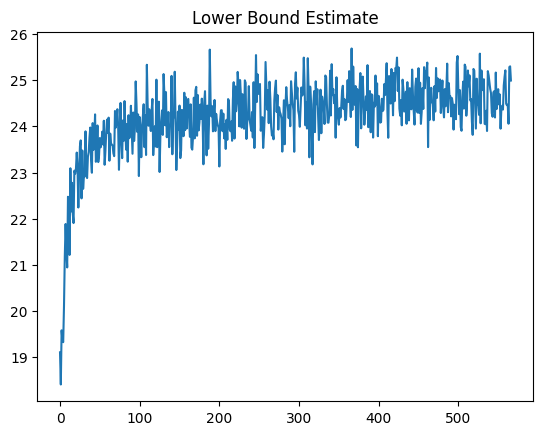

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

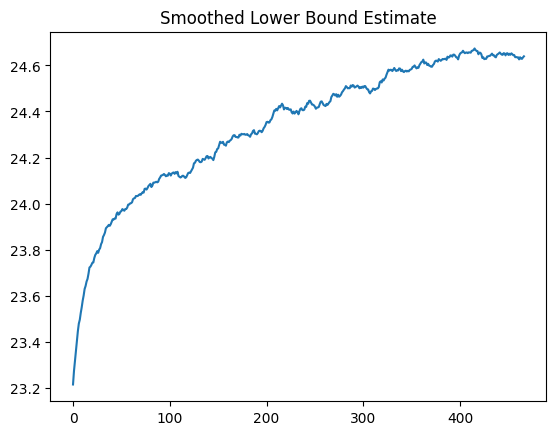

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[0]) + 1) / (1 + np.exp(best_theta_tilde[0]))
best_beta = (100 * np.exp(best_theta_tilde[1]) + 0) / (1 + np.exp(best_theta_tilde[1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[2]) + 0) / (1 + np.exp(best_theta_tilde[2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.57106849, 52.80242857,  0.51541083])

Text(0.5, 1.0, 'Posterior density of alpha')

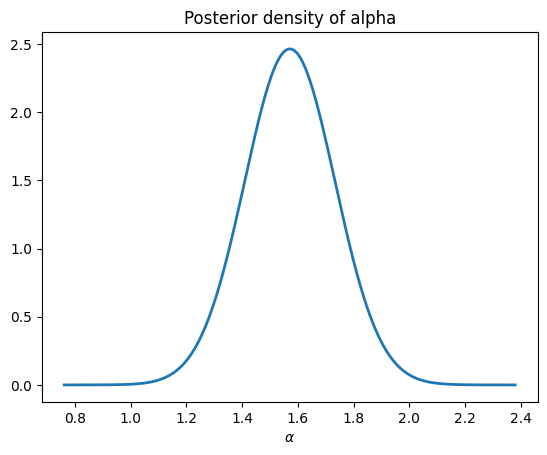

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

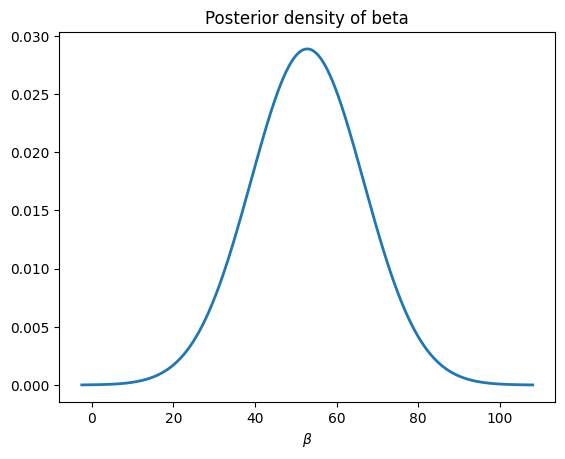

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

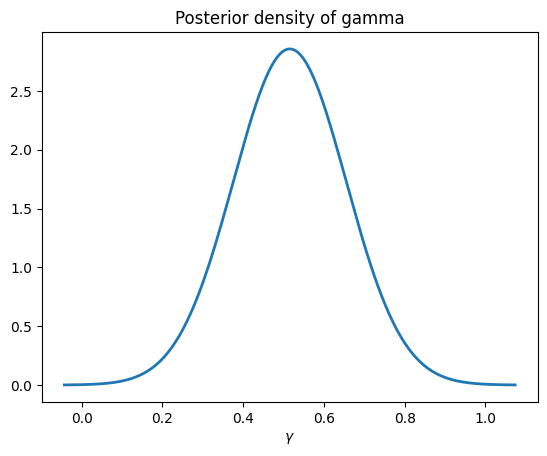

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')